# **Телеком**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

#### **Описание услуг**

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
2. Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
* Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
* Выделенная линия технической поддержки (Tech Support);
* Облачное хранилище файлов для резервного копирования данных (Online Backup);
* Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

#### **Описание данных**

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
* `contract` — информация о договорах;
* `personal` — персональные данные клиентов;
* `internet` — информация об интернет-услугах;
* `phone` — информация об услугах телефонии.

**Таблица `telecom.contract`**
* `customerID` — ID абонента;
* `BeginDate` — дата начала действия договора;
* `EndDate` — дата окончания действия договора;
* `Type` — тип оплаты: раз в год-два или ежемесячно;
* `PaperlessBilling` — электронный расчётный лист;
* `PaymentMethod` — тип платежа;
* `MonthlyCharges` — расходы за месяц;
* `TotalCharges` — общие расходы абонента.

**Таблица `telecom.personal`**
* `customerID` — ID пользователя;
* `gender` — пол;
* `SeniorCitizen` — является ли абонент пенсионером;
* `Partner` — есть ли у абонента супруг или супруга;
* `Dependents` — есть ли у абонента дети.

**Таблица `telecom.internet`**
* `customerID` — ID пользователя;
* `InternetService` — тип подключения;
* `OnlineSecurity` — блокировка опасных сайтов;
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
* `DeviceProtection` — антивирус;
* `TechSupport` — выделенная линия технической поддержки;
* `StreamingTV` — стриминговое телевидение;
* `StreamingMovies` — каталог фильмов.

**Таблица `telecom.phone`**
* `customerID` — ID пользователя;
* `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

# Шаг 1. Загрузка данных

In [1]:
!pip install catboost psycopg2 optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import psycopg2 #без этой библиотеки не работал код в colab
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import  Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D, BatchNormalization
import tensorflow as tf

from tqdm import notebook
from tqdm.auto import tqdm

RANDOM_STATE = 1022020

In [3]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [4]:
db_config = {
    'user': 'praktikum_student',
    'password': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'database': 'data-science-final'
}

In [5]:
connection = psycopg2.connect(**db_config) #установим соединение с базой данных PostgreSQL с использованием библиотеки psycopg2

In [6]:
query = 'SELECT * FROM telecom.contract;'

sample_telecom_contract = pd.read_sql_query(query, connection)
sample_telecom_contract.head(10)

<ipython-input-6-0c5fb9d0e3b4>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sample_telecom_contract = pd.read_sql_query(query, connection)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN


In [7]:
sample_telecom_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [8]:
query = 'SELECT * FROM telecom.personal;'

sample_telecom_personal = pd.read_sql_query(query, connection)
sample_telecom_personal.head(10)

<ipython-input-8-7797c0d4a0b5>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sample_telecom_personal = pd.read_sql_query(query, connection)


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [9]:
sample_telecom_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
query = 'SELECT * FROM telecom.internet;'

sample_telecom_internet = pd.read_sql_query(query, connection)
sample_telecom_internet.head(10)

<ipython-input-10-a0531a9eca3f>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sample_telecom_internet = pd.read_sql_query(query, connection)


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,6713-OKOMC,DSL,Yes,No,No,No,No,No
9,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


In [11]:
sample_telecom_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


**Вывод:**

В данном шаги нами были загружены необходимые библиотеки для исследования, а также выведены файлы, содержащиеся в базе данных.

# Шаг 2. Исследовательский анализ и предобработка данных

In [12]:
#Переименуем столбцы, удалим нулевой объект
sample_telecom_internet = sample_telecom_internet.rename(columns={'c1':'customerID', 'c2':'InternetService',
                         'c3':'OnlineSecurity', 'c4':'OnlineBackup',
                         'c5':'DeviceProtection', 'c6':'TechSupport',
                         'c7':'StreamingTV', 'c8':'StreamingMovies'}).drop([0]).reset_index(drop=True)
sample_telecom_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
query = 'SELECT * FROM telecom.phone;'

sample_telecom_phone = pd.read_sql_query(query, connection)
sample_telecom_phone.head(10)

<ipython-input-13-87057cd8d309>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sample_telecom_phone = pd.read_sql_query(query, connection)


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No
8,9763-GRSKD,No
9,7469-LKBCI,No


In [14]:
sample_telecom_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [15]:
#переименуем столбцы, удалим 0 объект
sample_telecom_phone = sample_telecom_phone.rename(columns={'c1':'customerID', 'c2':'MultipleLines'}).drop([0]).reset_index(drop=True)
sample_telecom_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
print(f'Размер таблицы: {sample_telecom_contract.shape}\n')
print(f'Типы данных таблицы: \n{sample_telecom_contract.dtypes}\n')
print(f'Пропусков в таблице: \n{sample_telecom_contract.isna().sum()}\n')
print(f'Дубликатов в таблице: {sample_telecom_contract.duplicated().sum()}\n')

Размер таблицы: (7043, 8)

Типы данных таблицы: 
customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

Пропусков в таблице: 
customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

Дубликатов в таблице: 0



In [17]:
print(f'Размер таблицы: {sample_telecom_personal.shape}\n')
print(f'Типы данных таблицы: \n{sample_telecom_personal.dtypes}\n')
print(f'Пропусков в таблице: \n{sample_telecom_personal.isna().sum()}\n')
print(f'Дубликатов в таблице: {sample_telecom_personal.duplicated().sum()}\n')

Размер таблицы: (7043, 5)

Типы данных таблицы: 
customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

Пропусков в таблице: 
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Дубликатов в таблице: 0



In [18]:
print(f'Размер таблицы: {sample_telecom_internet.shape}\n')
print(f'Типы данных таблицы: \n{sample_telecom_internet.dtypes}\n')
print(f'Пропусков в таблице: \n{sample_telecom_internet.isna().sum()}\n')
print(f'Дубликатов в таблице: {sample_telecom_internet.duplicated().sum()}\n')

Размер таблицы: (5517, 8)

Типы данных таблицы: 
customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

Пропусков в таблице: 
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Дубликатов в таблице: 0



In [19]:
print(f'Размер таблицы: {sample_telecom_phone.shape}\n')
print(f'Типы данных таблицы: \n{sample_telecom_phone.dtypes}\n')
print(f'Пропусков в таблице: \n{sample_telecom_phone.isna().sum()}\n')
print(f'Дубликатов в таблице: {sample_telecom_phone.duplicated().sum()}\n')

Размер таблицы: (6361, 2)

Типы данных таблицы: 
customerID       object
MultipleLines    object
dtype: object

Пропусков в таблице: 
customerID       0
MultipleLines    0
dtype: int64

Дубликатов в таблице: 0



In [20]:
sample_telecom_contract[sample_telecom_contract['TotalCharges'].isna()] #Изучим пропуски в таблице Total Charges

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


In [21]:
#Исправим пропуски
sample_telecom_contract['TotalCharges'] = sample_telecom_contract['TotalCharges'].fillna(0)
sample_telecom_contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
dtype: int64

In [22]:
#Проверим клиентов на аномалии (у которых есть итоговая сумма и которые не отключились)
sample_telecom_contract[(sample_telecom_contract['EndDate'].isna()) & (sample_telecom_contract['TotalCharges']>0)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
280,1106-HRLKZ,2019-01-28,None,Two year,No,Mailed check,19.60,808.95
546,2430-RRYUW,2019-04-03,None,One year,Yes,Mailed check,54.80,3465.70
605,8879-XUAHX,2019-04-19,None,Two year,Yes,Electronic check,116.25,8564.75
841,8631-XVRZL,2019-01-26,None,One year,Yes,Mailed check,20.15,163.70
878,4324-BZCKL,2019-08-15,None,Month-to-month,Yes,Mailed check,55.55,551.30
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


Мы видим 2 ошибки. 1я Клиент ушёл и у нас не отмечена дата окончания срока действия оговора `EndDate`.
2я - Клиент пользуется услугой, но не имеются его общие расходы `TotalCharges`.

In [23]:
def hist_box(df, col):
    fig,ax = plt.subplots(2,1, sharex=True, figsize=(6,6),
                          gridspec_kw={'height_ratios': [3, 1]})

    sns.histplot(data=df,x=col,bins=100,
                 ax=ax[0]).set(title=f'Distribution of {col}')

    sns.boxplot(data=df, x=col, ax=ax[1])

    return plt.show();

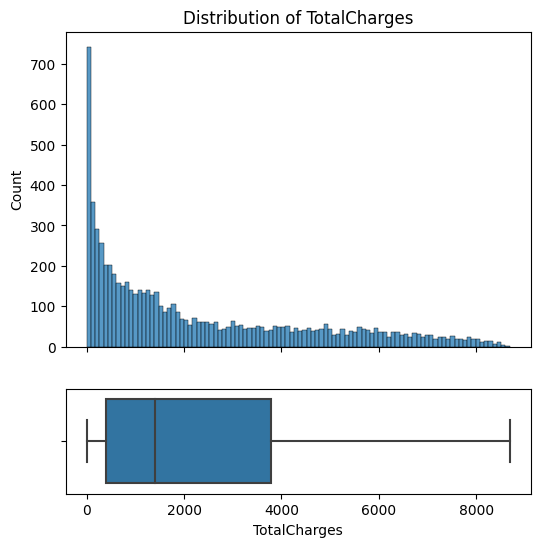

In [24]:
hist_box(sample_telecom_contract,'TotalCharges')

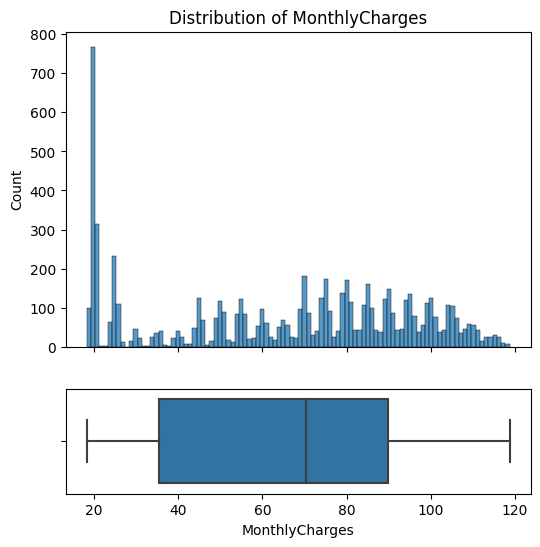

In [25]:
hist_box(sample_telecom_contract,'MonthlyCharges')

In [26]:
#Исправим итоговую сумму
def corrected_TotalCharges(dataframe):
    correction = sample_telecom_contract['EndDate'].isna()
    dataframe.loc[correction, 'TotalCharges'] = 0
    return dataframe

In [27]:
correction  = corrected_TotalCharges(sample_telecom_contract)

sample_telecom_contract[sample_telecom_contract['EndDate'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,0.0
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,0.0
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,0.0
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,0.0
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,0.0
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,0.0
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,0.0
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,0.0
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,0.0


In [28]:
#Исправим дату конца договора
def end_contract(dataframe):
    if dataframe['EndDate'] is None:
        dataframe['target'] = 0
        dataframe['EndDate'] = '2020-02-01'
    return dataframe

In [29]:
sample_telecom_contract = sample_telecom_contract.apply(end_contract, axis=1)
sample_telecom_contract['EndDate'] = pd.to_datetime(sample_telecom_contract['EndDate'])
sample_telecom_contract['BeginDate'] = pd.to_datetime(sample_telecom_contract['BeginDate'])
sample_telecom_contract['target'] = sample_telecom_contract['target'].fillna(1).astype(int)
sample_telecom_contract.head()

,BeginDate,EndDate,MonthlyCharges,PaperlessBilling,PaymentMethod,TotalCharges,Type,customerID,target
0,2020-02-01,2020-02-01,52.55,Yes,Bank transfer (automatic),0.00,Two year,4472-LVYGI,0
1,2020-02-01,2020-02-01,20.25,No,Mailed check,0.00,Two year,3115-CZMZD,0
2,2018-08-09,2019-12-01,53.85,Yes,Mailed check,108.15,Month-to-month,3668-QPYBK,1
3,2020-02-01,2020-02-01,80.85,No,Mailed check,0.00,Two year,5709-LVOEQ,0
4,2019-01-26,2019-11-01,70.70,Yes,Electronic check,151.65,Month-to-month,9237-HQITU,1


In [30]:
#исправим итоговую сумму
def corrected_TotalCharges_2(dataframe):
    if dataframe['Type'] == 'Month-to-month':
        value = (dataframe['EndDate'] - dataframe['BeginDate']).days / 30 * dataframe['MonthlyCharges']
        dataframe['TotalCharges'] = value
    return dataframe

In [31]:
sample_telecom_contract = sample_telecom_contract.apply(corrected_TotalCharges_2, axis=1)

In [32]:
sample_telecom_contract.head()

,BeginDate,EndDate,MonthlyCharges,PaperlessBilling,PaymentMethod,TotalCharges,Type,customerID,target
0,2020-02-01,2020-02-01,52.55,Yes,Bank transfer (automatic),0.000,Two year,4472-LVYGI,0
1,2020-02-01,2020-02-01,20.25,No,Mailed check,0.000,Two year,3115-CZMZD,0
2,2018-08-09,2019-12-01,53.85,Yes,Mailed check,859.805,Month-to-month,3668-QPYBK,1
3,2020-02-01,2020-02-01,80.85,No,Mailed check,0.000,Two year,5709-LVOEQ,0
4,2019-01-26,2019-11-01,70.70,Yes,Electronic check,657.510,Month-to-month,9237-HQITU,1


In [33]:
sample_telecom_contract.tail()

,BeginDate,EndDate,MonthlyCharges,PaperlessBilling,PaymentMethod,TotalCharges,Type,customerID,target
7038,2019-01-21,2020-02-01,21.15,Yes,Bank transfer (automatic),0.000000,Two year,2569-WGERO,0
7039,2019-02-26,2020-02-01,84.80,Yes,Mailed check,0.000000,One year,6840-RESVB,0
7040,2019-09-02,2020-02-01,103.20,Yes,Credit card (automatic),0.000000,One year,2234-XADUH,0
7041,2019-06-26,2020-02-01,29.60,Yes,Electronic check,217.066667,Month-to-month,4801-JZAZL,0
7042,2019-04-18,2020-02-01,105.65,Yes,Bank transfer (automatic),0.000000,Two year,3186-AJIEK,0


In [34]:
#Проверка временного интервала
# Минимальная и максимальная дата для столбца 'BeginDate'
begin_date_min = sample_telecom_contract['BeginDate'].min()
begin_date_max = sample_telecom_contract['BeginDate'].max()

# Минимальная и максимальная дата для столбца 'EndDate'
end_date_min = sample_telecom_contract['EndDate'].min()
end_date_max = sample_telecom_contract['EndDate'].max()

print("Минимальная дата для 'BeginDate':", begin_date_min)
print("Максимальная дата для 'BeginDate':", begin_date_max)
print("Минимальная дата для 'EndDate':", end_date_min)
print("Максимальная дата для 'EndDate':", end_date_max)

Минимальная дата для 'BeginDate': 2018-04-17 00:00:00
Максимальная дата для 'BeginDate': 2020-02-01 00:00:00
Минимальная дата для 'EndDate': 2019-10-01 00:00:00
Максимальная дата для 'EndDate': 2020-02-01 00:00:00


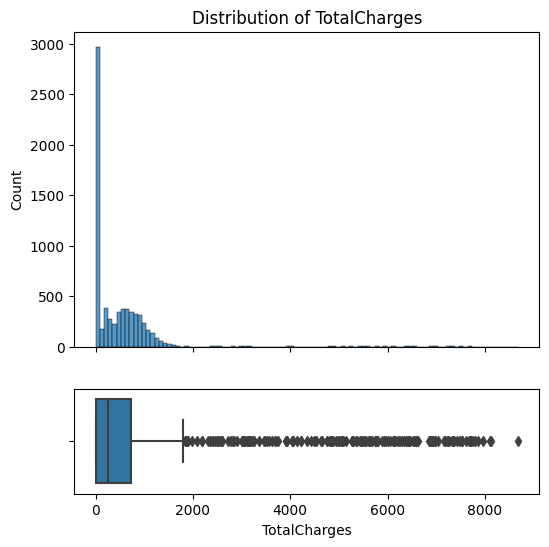

In [35]:
hist_box(sample_telecom_contract,'TotalCharges')

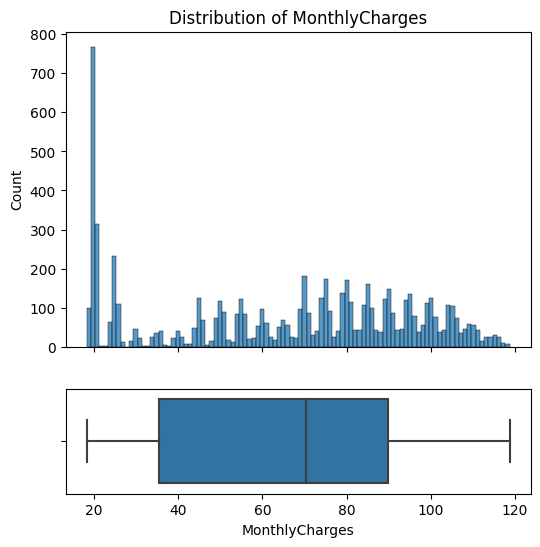

In [36]:
hist_box(sample_telecom_contract,'MonthlyCharges')

In [37]:
#Объединяем всё в один датафейм
df = sample_telecom_personal.merge(sample_telecom_contract, on ='customerID', how='inner')
df = df.merge(sample_telecom_internet, on ='customerID', how = 'outer')
df = df.merge(sample_telecom_phone, on ='customerID', how = 'outer')
df.name = 'data'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   MonthlyCharges    7043 non-null   float64       
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  TotalCharges      7043 non-null   float64       
 11  Type              7043 non-null   object        
 12  target            7043 non-null   int64         
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

In [38]:
df.isna().sum() #Проверим данные на количество пропусков

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
MonthlyCharges         0
PaperlessBilling       0
PaymentMethod          0
TotalCharges           0
Type                   0
target                 0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [39]:
#заполним имеющиеся пропуски наиболее часто повторяющимся значением
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(df[df.columns[13:,]])

df[df.columns[13:,]] = imputer.transform(df[df.columns[13:,]])

In [40]:
#Заполним пропуски

# Создаём объект SimpleImputer с стратегией 'most_frequent'
imputer = SimpleImputer(strategy='most_frequent')

# Выберем подмножество столбцов
columns_to_impute = df.columns[13:]

# Применяем SimpleImputer к выбранным столбцам
imputer.fit(df[columns_to_impute])

# Заполним пропуски
df[columns_to_impute] = imputer.transform(df[columns_to_impute])


In [41]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
MonthlyCharges      0
PaperlessBilling    0
PaymentMethod       0
TotalCharges        0
Type                0
target              0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   MonthlyCharges    7043 non-null   float64       
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  TotalCharges      7043 non-null   float64       
 11  Type              7043 non-null   object        
 12  target            7043 non-null   int64         
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

In [43]:
# Заменим все значения в категориальный признаках (Yes/No) числовыми:
for column in df:
    tmp = df[column].unique()
    tmp.sort()
    if list(tmp) == ['No', 'Yes']:
        df[column] = (df[column] == 'Yes').astype('int')
        df[column] = df[column].astype('int')

In [44]:
#Посмотрим результат замены

df['TotalCharges'].unique()

array([276.61      ,   0.        , 859.805     , ..., 796.14666667,
       626.97666667, 217.06666667])

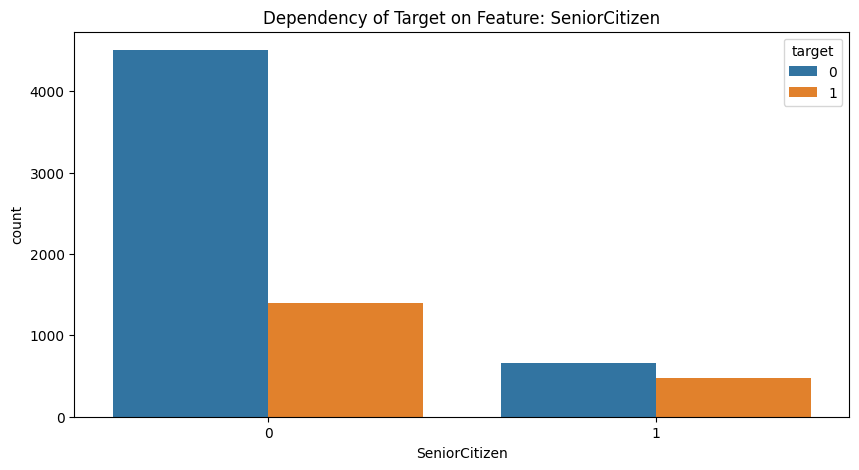

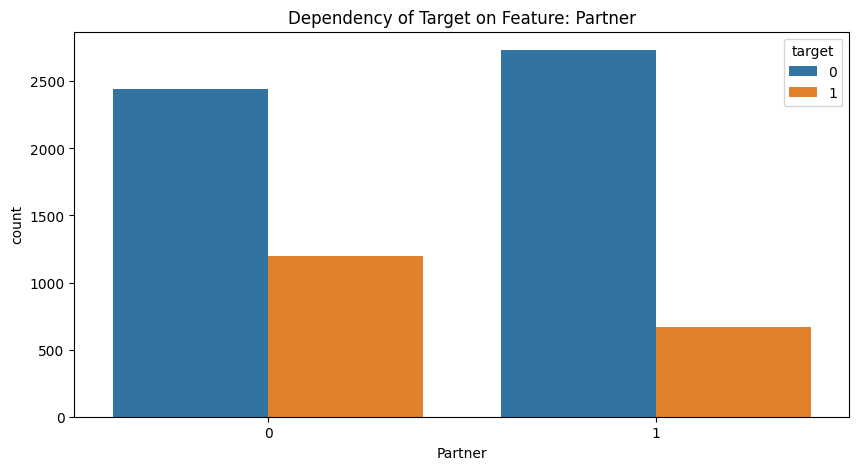

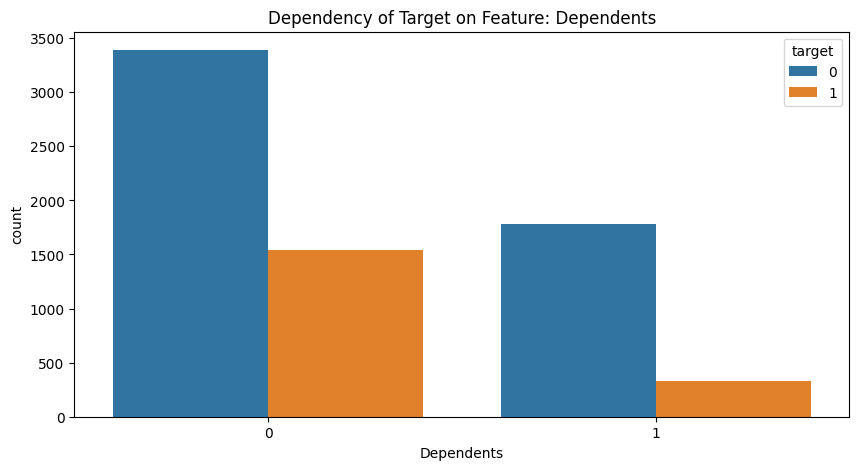

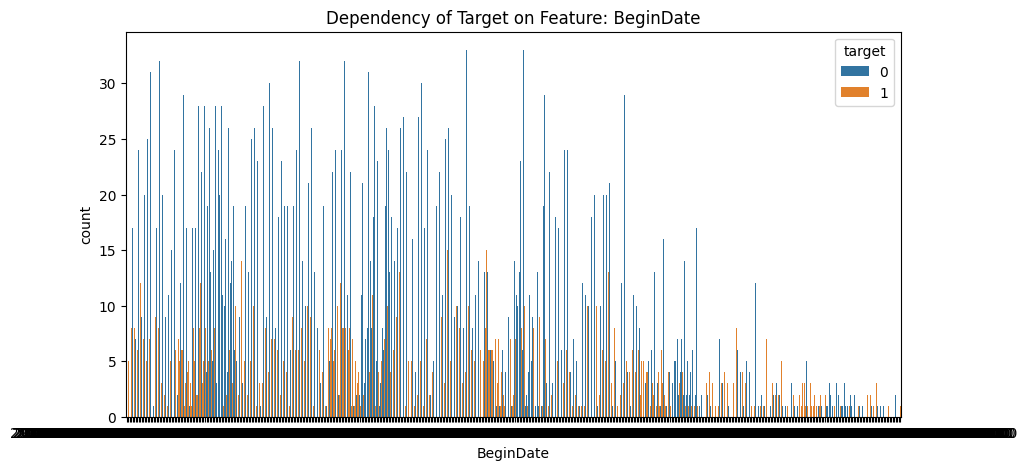

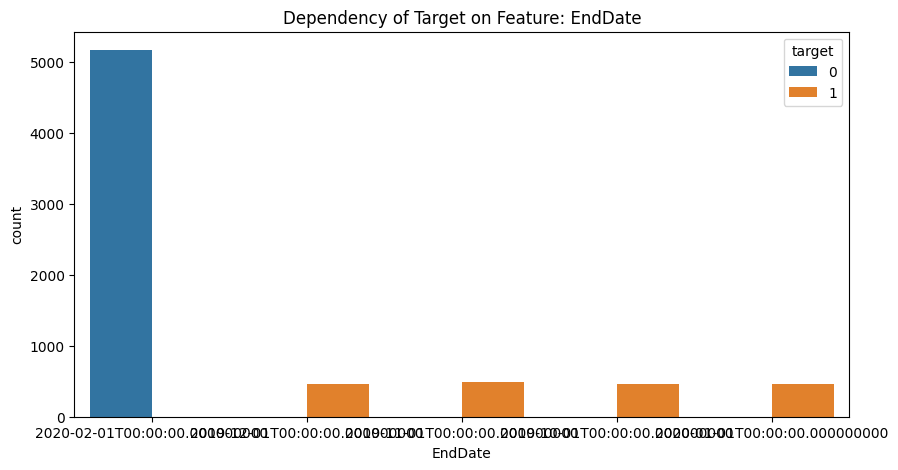

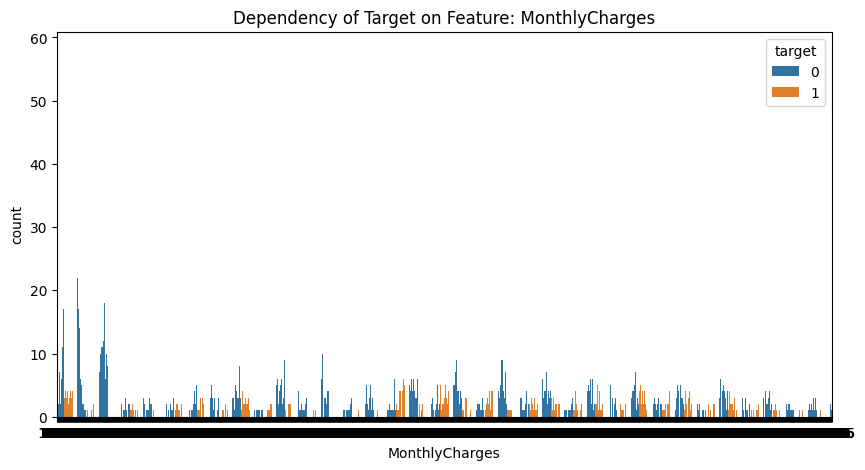

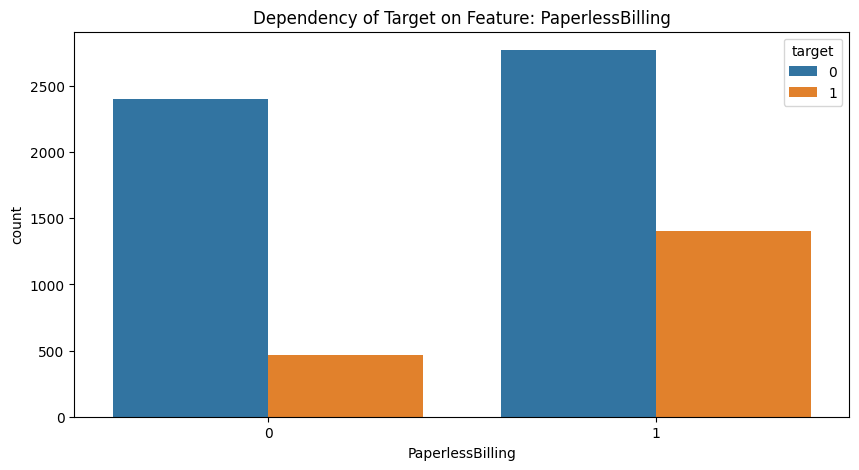

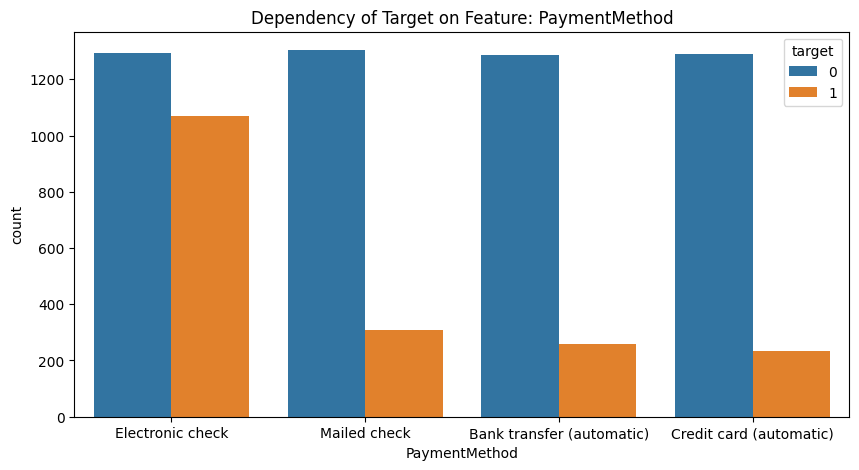

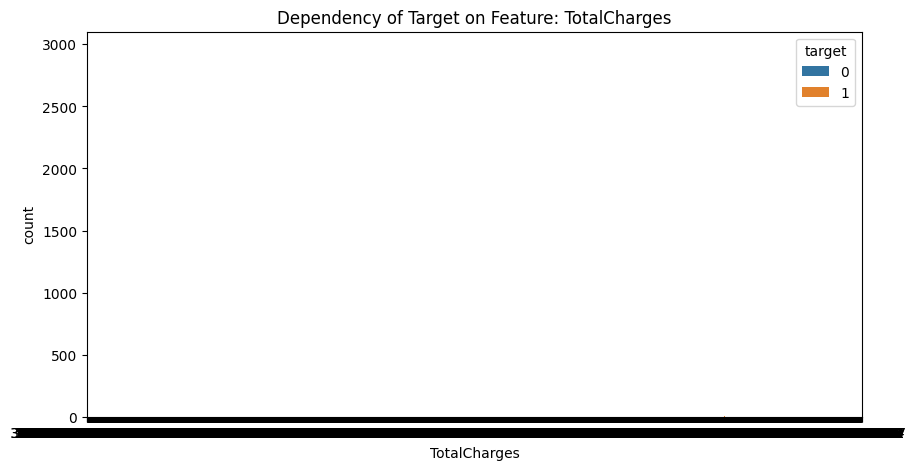

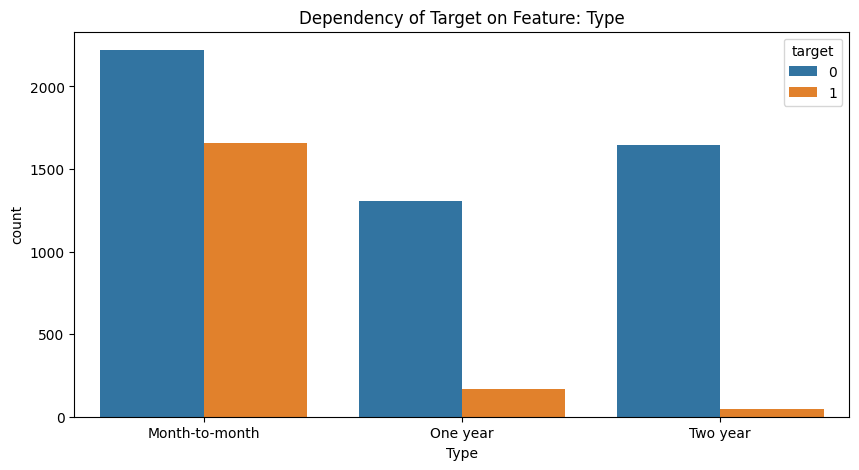

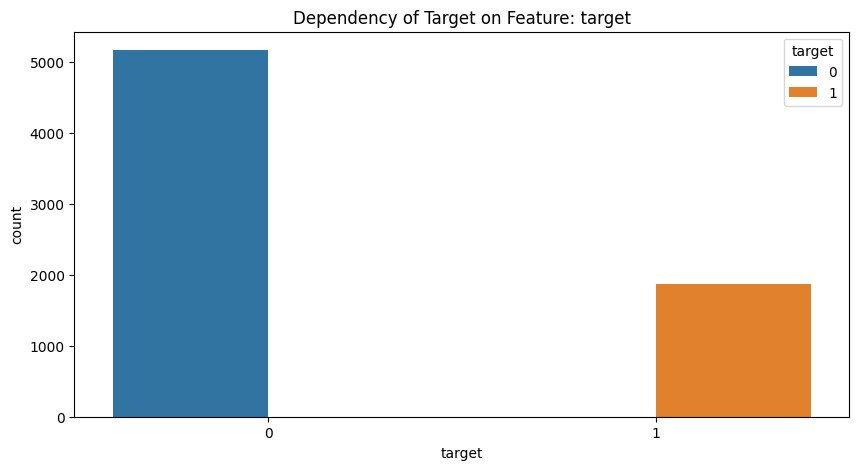

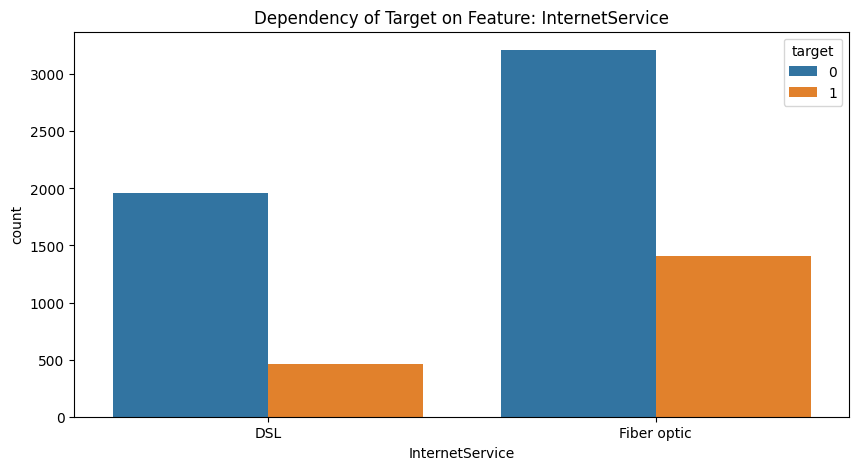

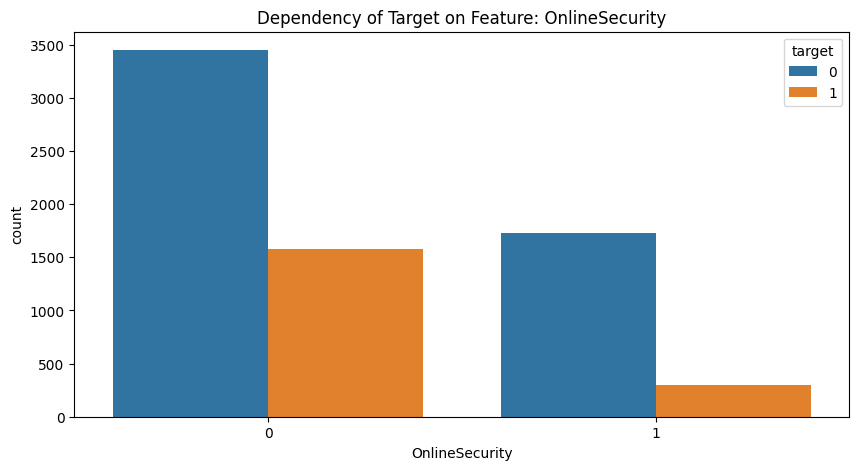

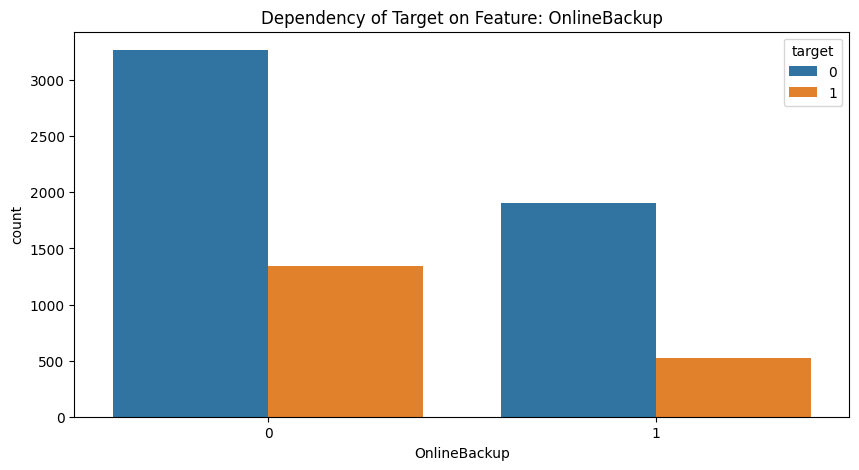

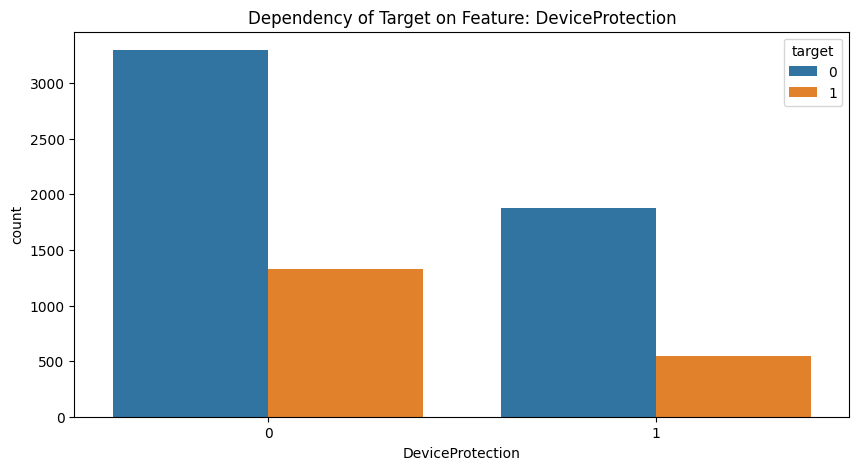

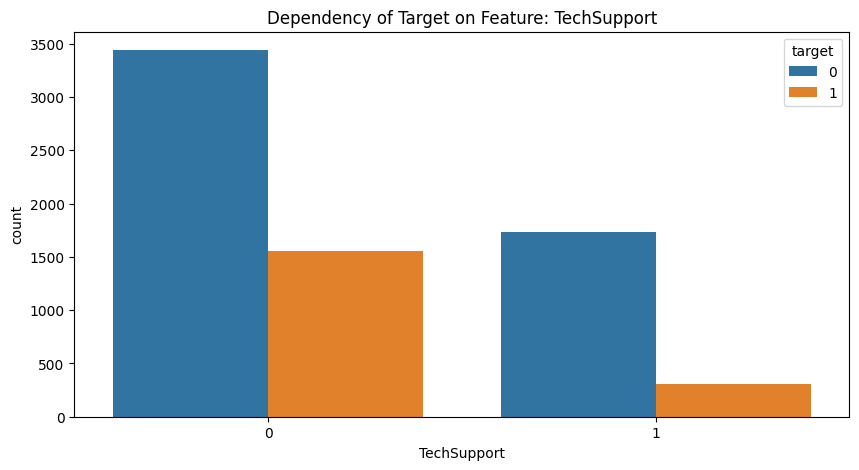

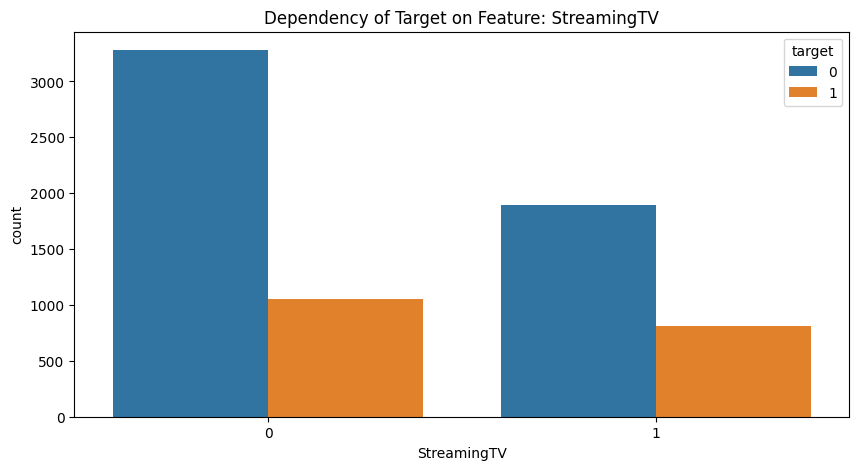

In [45]:
#Рассмотрим зависимость целевого признака от других признаков
def plot_countplot(data, features, target_column, drop_columns=[]):
    data = df.drop(drop_columns, axis=1)

    for feature in features:
        plt.figure(figsize=(10, 5))
        plt.title(f'Dependency of Target on Feature: {feature}')
        sns.countplot(x=feature, hue=target_column, data=data)
        plt.show()

categorical_features = df.columns[2:-2]
target_column = 'target'
drop_columns = []

plot_countplot(df, categorical_features, target_column, drop_columns)

Исходя из вышеприведённых графиков, мы можем вывести типичного клиента, который будет отказываться от услуг связи. Он совершает ежемесячные переводы на счёт, подключается к Интернету через оптическому волокну, холост, без семьи, без услуг тех. поддежки.

In [46]:
#Построим также матрицу корреляций признаков
#fig, ax = plt.subplots(figsize=(15,7))
#sns.heatmap(df.corr(), annot=True)
#plt.tight_layout()
#plt.show()

Наблюдается сильная зависимость между Monthly Charges и StreamingTV +  StreamingMovies + довольно весомая MultipleLines.

Также наблюдается сильная зависисость между StreamingMovies и StreamingTV, а также между MultipleLines с MonthlyCharges.

**Вывод:**

В ходе предоработки данных мы проверили датасеты на пропуски, дубликаты и пустые значения. Дубликатов обнаружено не было, однако были пропуски в `EndDate` и `TotalCharges`. Пропуски в `EndDate` а пропуски в `TotalCharges` мы решили заполнить нулями, поскольку был небольшой процент от выборки в 11 строк. При рассмотрении столбца `EndDate` мы заметили 2 ошибки, а именно, что были данные, где клиент ушёл и у нас не отмечена дата окончания срока действия договора `EndDate`. Другая - Клиент пользуется услугой, но не имеются его общие расходы `TotalCharges`. В итоге мы решили исправить итоговую сумму и дату конца договора.

Далее мы заметили пропуски из-за несоответствия размерности строк. В итоге мы решили заполнить имеющиеся пропуски наиболее часто повторяющимся значением. Затем мы объединили таблицы в единый датасет и опредилили портреттипичного клиента, который готов расторгнуть договор с компанией по оказываемым услугами рассмотрели взаимозависимости меду признаками на матрице корреляций признаков.

In [47]:
!pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 10.6 MB/s eta 0:00:00


In [48]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [49]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['SeniorCitizen', 'Partner', 'Dependents', 'MonthlyCharges', 'PaperlessBilling', 'TotalCharges', 'target', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customerID is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customerID can be slow.
  warnings.warn(


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,MonthlyCharges,PaperlessBilling,PaymentMethod,...,Type,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
gender,1.0,1.00,0.00,0.00,0.00,0.09,0.00,0.01,0.00,0.00,...,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,1.0,0.00,1.00,0.02,0.32,0.14,0.12,0.30,0.24,0.29,...,0.09,0.23,0.17,0.06,0.10,0.09,0.09,0.16,0.19,0.22
Partner,1.0,0.00,0.02,1.00,0.65,0.14,0.12,0.20,0.01,0.24,...,0.18,0.23,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.22
Dependents,1.0,0.00,0.32,0.65,1.00,0.08,0.13,0.18,0.17,0.22,...,0.15,0.25,0.08,0.12,0.03,0.01,0.10,0.02,0.06,0.03
BeginDate,1.0,0.09,0.14,0.14,0.08,1.00,0.52,0.19,0.04,0.10,...,0.13,0.49,0.00,0.11,0.00,0.08,0.00,0.06,0.03,0.06
EndDate,1.0,0.00,0.12,0.12,0.13,0.52,1.00,0.32,0.16,0.21,...,0.36,1.00,0.10,0.14,0.07,0.05,0.13,0.05,0.05,0.03
MonthlyCharges,1.0,0.01,0.30,0.20,0.18,0.19,0.32,1.00,0.47,0.40,...,0.39,0.36,0.95,0.55,0.63,0.67,0.58,0.84,0.83,0.68
PaperlessBilling,1.0,0.00,0.24,0.01,0.17,0.04,0.16,0.47,1.00,0.37,...,0.11,0.30,0.10,0.00,0.20,0.16,0.06,0.34,0.33,0.25
PaymentMethod,1.0,0.00,0.29,0.24,0.22,0.10,0.21,0.40,0.37,1.00,...,0.28,0.45,0.16,0.26,0.28,0.31,0.27,0.38,0.38,0.34


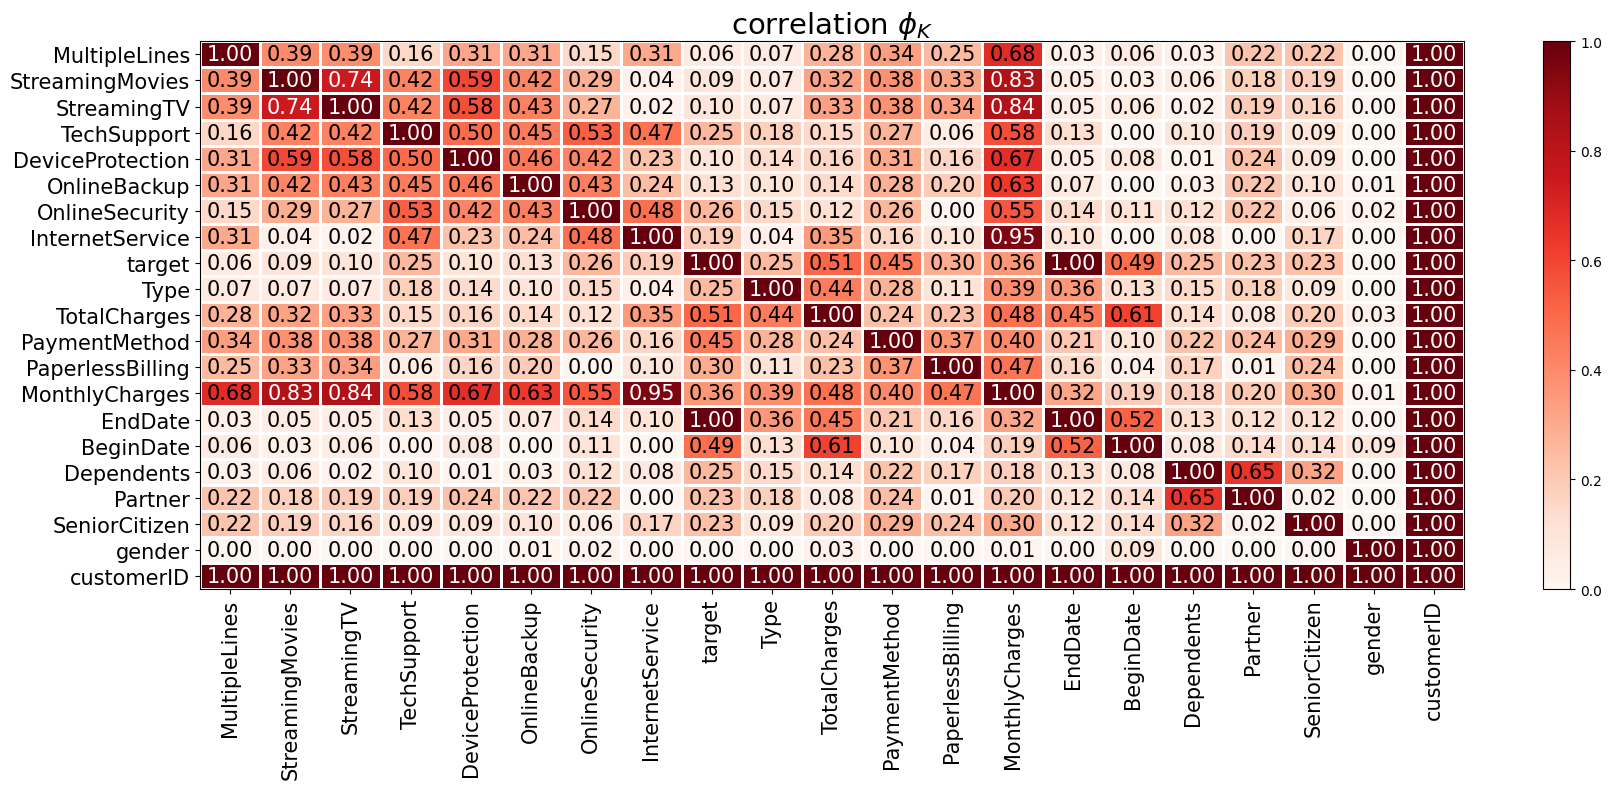

In [50]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0,
                        vmax=1,
                        color_map="Reds",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(18, 8))
plt.tight_layout()

In [51]:
df.drop(['BeginDate'], axis=1, inplace=True)
'BeginDate' in df.columns

False

In [52]:
df.drop(['EndDate'], axis=1, inplace=True)
'EndDate' in df.columns

False

In [53]:
df['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

# Шаг 3. Обучение моделей

In [54]:
# Добавим признаки для обучения модели
features = pd.DataFrame(np.c_[np.array(df[['MonthlyCharges', 'TotalCharges',
                                      'SeniorCitizen']])])
target = df['target']
display(features.head())
display(target.head())

,0,1,2
0,29.85,276.610,0.0
1,56.95,0.000,0.0
2,53.85,859.805,0.0
3,42.30,0.000,0.0
4,70.70,657.510,0.0


0    0
1    0
2    1
3    0
4    1
Name: target, dtype: int64

In [55]:
# Добавим признаки для обучения модели:
#df_model = df[['Type','PaperlessBilling', 'PaymentMethod','MonthlyCharges', 'target',
#               'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']]

#numeric_names = ['MonthlyCharges']

In [56]:
#features = df_model.drop('target', axis=1)
#target = df_model['target']

features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

#Выведем размер выборок
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(5282, 3)

(1761, 3)

(5282,)

(1761,)

Применим OneHotEncoder чтобы преобразовать категориальные переменные в колчественные

In [57]:
from sklearn.compose import ColumnTransformer

numerics = list(features.select_dtypes(include=['int64', 'float64']).columns)
categorical = list(features.select_dtypes(include='object').columns)

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

col_transformer.fit(features_train)
features_train = col_transformer.transform(features_train)
features_test = col_transformer.transform(features_test)

In [58]:
#categorical_features = ['PaymentMethod', 'InternetService', 'Type']

#features_train = pd.get_dummies(features_train, columns=categorical_features)

#features_test = pd.get_dummies(features_test, columns=categorical_features)

In [59]:
#scaler = StandardScaler()

#scaler.fit(features_train[numeric_names])

#features_train[numeric_names] = scaler.transform(features_train[numeric_names])

#features_test[numeric_names] = scaler.transform(features_test[numeric_names])

#print(features_train[numeric_names].sample(10, random_state=RANDOM_STATE))

In [60]:
const_model = [1 for i in range(len(target_test))]
const_roc_auc = roc_auc_score(target_test.reset_index(drop=True), const_model)
print(const_roc_auc)

0.5


**Модель логистической регрессии**

In [61]:
%%time

model_lr = LogisticRegression(fit_intercept=True, class_weight='balanced', random_state=RANDOM_STATE, solver='liblinear')

regression_parameters = {'C': [0.1, 1, 10]}

regression_grid = GridSearchCV(model_lr, regression_parameters, scoring='roc_auc', cv=3, error_score='raise')
regression_grid.fit(features_train, target_train)

model_lr.fit(features_train, target_train)
lr_cv_score = pd.Series(cross_val_score(model_lr, features_train, target_train, scoring='roc_auc', cv=3)).mean()

print('Среднее качество модели логистической регрессии на кросс-валидации', lr_cv_score)

Среднее качество модели логистической регрессии на кросс-валидации 0.8427645769183529
CPU times: user 130 ms, sys: 3.97 ms, total: 134 ms
Wall time: 141 ms


In [62]:
lr_params = regression_grid.best_params_
lr_score = regression_grid.score(features_train, target_train)
print(lr_params)
print(lr_score)

{'C': 0.1}
0.8447910385752312


**Модель решающего дерева**

In [63]:
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)

max_depth_values = range(1, 10)
min_impurity_values = np.arange(0.0, 0.01, 0.001)

parameter_combinations = []

for max_depth in max_depth_values:
    for min_impurity in min_impurity_values:
        parameter_combinations.append({
            'criterion': ['gini', 'entropy'],
            'max_depth': [max_depth],
            'min_impurity_decrease': [min_impurity]
        })

#Увеличиваем n_jobs для параллельных вычислений
dt_grid = GridSearchCV(model_dt, parameter_combinations, scoring='roc_auc', n_jobs=-1, cv=8, verbose=10)
dt_grid.fit(features_train, target_train)

Fitting 8 folds for each of 180 candidates, totalling 1440 fits


GridSearchCV(cv=8,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1022020),
             n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'], 'max_depth': [1],
                          'min_impurity_decrease': [0.0]},
                         {'criterion': ['gini', 'entropy'], 'max_depth': [1],
                          'min_impurity_decrease': [0.001]},
                         {'criterion': ['gini', 'entropy'], 'max_depth': [1],
                          'min_impurity_decrease'...
                         {'criterion': ['gini', 'entropy'], 'max_depth': [3],
                          'min_impurity_decrease': [0.006]},
                         {'criterion': ['gini', 'entropy'], 'max_depth': [3],
                          'min_impurity_decrease': [0.007]},
                         {'criterion': ['gini', 'entropy'], 'max_depth': [3],
                          'min_impurity_decrease': [0.008]},
                         {'criterion': ['gini', 'entropy'], 'max_depth': [3],
                          'min_impurity_decrease': [0.009000000000000001]}, ...],
             scoring='roc_auc', verbose=10)

In [64]:
y_pred_proba = dt_grid.predict_proba(features_test)[:, 1]

# Вычисляем AUC-ROC на тестовом наборе данных
auc_roc = roc_auc_score(target_test, y_pred_proba)
print('AUC-ROC на тестовом наборе данных:', auc_roc)

AUC-ROC на тестовом наборе данных: 0.8607516490208473


In [93]:
dt_params = dt_grid.best_params_
dt_cv_score = dt_grid.score(features_train, target_train)
print(dt_params)
print(dt_cv_score)

{'criterion': 'entropy', 'max_depth': 4, 'min_impurity_decrease': 0.0}
0.8557099026427637


**Модель случайного леса**

In [66]:
%%time

model_rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

rf_parameters = {
    'n_estimators': range(20, 40, 5),
    'max_depth': range(4, 8, 2),
    'min_samples_leaf': range(3,5),
    'min_samples_split': range(2,6,2),
}

rf_grid = GridSearchCV(model_rf, rf_parameters, scoring='roc_auc', cv=3)
rf_grid.fit(features_train, target_train)

model_rf.fit(features_train, target_train)
rf_cv_score = pd.Series(cross_val_score(model_rf, features_train, target_train, scoring='roc_auc', cv=3)).mean()

print('Среднее качество модели случайного леса на кросс-валидации', rf_cv_score)

Среднее качество модели случайного леса на кросс-валидации 0.836980381437661
CPU times: user 15.8 s, sys: 428 ms, total: 16.2 s
Wall time: 26.2 s


In [67]:
rf_params = rf_grid.best_params_
rf_score = rf_grid.score(features_train, target_train)
print(rf_params)
print(rf_score)

{'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 25}
0.8820026067326501


**Catboost**

In [68]:
%%time

model_cb = CatBoostClassifier(logging_level='Silent', loss_function='Logloss')
parameters_cb = {'max_depth': np.arange(4, 11),
                  'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1],
                  'iterations': [500,1000,1500,2000]}
catboost_grid = GridSearchCV(model_cb,
                             parameters_cb,
                             cv=3,
                             scoring=['roc_auc', 'precision'],
                             refit = 'roc_auc').fit(features_train, target_train)

CPU times: user 39min 11s, sys: 3min 2s, total: 42min 14s
Wall time: 24min 37s


In [69]:
cb_cv_score = pd.Series(cross_val_score(model_cb, features_train, target_train, scoring='roc_auc', cv=3)).mean()

print('Среднее качество Catboost на кросс-валидации', cb_cv_score)

Среднее качество Catboost на кросс-валидации 0.8550896287260285


In [70]:
cb_params = catboost_grid.best_params_
cb_score = catboost_grid.score(features_train, target_train)
print(cb_params)
print(cb_score)

{'iterations': 1000, 'learning_rate': 0.01, 'max_depth': 5}
0.8913367501507419


In [71]:
#from catboost import CatBoostClassifier, Pool, cv

#feature_names = list(features_train.columns)
#cat_features = list(set(feature_names) - set(numeric_names))

#train_pool = Pool(data=features_train,
#                  label=target_train,
#                  cat_features=cat_features,
#                  feature_names=feature_names)
#test_pool = Pool(data=features_test,
#                 label=target_test,
#                 cat_features=cat_features,
#                 feature_names=feature_names)

In [72]:
#zeroes = df['target'].value_counts()[0]
#ones = df['target'].value_counts()[1]

#print(df['target'].value_counts())

In [73]:
#%%time

#class_weights = [1, zeroes/ones]

#model_cb = CatBoostClassifier(class_weights=class_weights, iterations=30)

#cb_parameters = {'depth': [4, 8]}

#cb_grid = GridSearchCV(model_cb, cb_parameters, scoring='roc_auc', cv=3)
#cb_grid.fit(features_train, target_train)

#model_cb.fit(features_train, target_train)
#cb_cv_score = pd.Series(cross_val_score(model_cb, features_train, target_train, scoring='roc_auc', cv=3)).mean()

#print('Среднее качество Catboost на кросс-валидации', cb_cv_score)
#print(f'ROC AUC: {roc_auc_cb:.3f}')

**Модель нейронной сети**

In [74]:
NN = Sequential()
NN.add(Dense(256, input_shape=(features_train.shape[1],), activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(128, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(1, activation='sigmoid'))  # Используем активацию 'sigmoid' для бинарной классификации

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='binary_crossentropy',  # Используем binary_crossentropy для бинарной классификации
           metrics=[tf.keras.metrics.AUC()])

NN.build()

NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               5

In [75]:
NN.fit(
    features_train, target_train,
    validation_data=(features_test, target_test),
    batch_size=32, epochs=10,
    verbose=2, shuffle=True
)

Epoch 1/10
166/166 - 10s - loss: 0.6592 - auc: 0.7260 - val_loss: 0.8106 - val_auc: 0.7257 - 10s/epoch - 62ms/step
Epoch 2/10
166/166 - 1s - loss: 0.5774 - auc: 0.8249 - val_loss: 0.7811 - val_auc: 0.8215 - 1s/epoch - 6ms/step
Epoch 3/10
166/166 - 1s - loss: 0.5503 - auc: 0.8387 - val_loss: 0.6192 - val_auc: 0.8451 - 972ms/epoch - 6ms/step
Epoch 4/10
166/166 - 1s - loss: 0.5405 - auc: 0.8386 - val_loss: 0.5090 - val_auc: 0.8571 - 995ms/epoch - 6ms/step
Epoch 5/10
166/166 - 1s - loss: 0.5245 - auc: 0.8432 - val_loss: 0.4786 - val_auc: 0.8576 - 1s/epoch - 8ms/step
Epoch 6/10
166/166 - 2s - loss: 0.5212 - auc: 0.8367 - val_loss: 0.4700 - val_auc: 0.8563 - 2s/epoch - 9ms/step
Epoch 7/10
166/166 - 1s - loss: 0.5072 - auc: 0.8465 - val_loss: 0.4672 - val_auc: 0.8565 - 1s/epoch - 7ms/step
Epoch 8/10
166/166 - 1s - loss: 0.5082 - auc: 0.8387 - val_loss: 0.4605 - val_auc: 0.8569 - 986ms/epoch - 6ms/step
Epoch 9/10
166/166 - 1s - loss: 0.5022 - auc: 0.8432 - val_loss: 0.4535 - val_auc: 0.8546 - 

In [76]:
predicted_probabilities = NN.predict(features_test)

56/56 [==============================] - 0s 2ms/step


In [77]:
predicted_classes = (predicted_probabilities > 0.5).astype(int)

In [78]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(target_test, predicted_classes)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7791027825099376


**Вывод:**

На даном шаге была разделена выбока на обучающую и тестовую в соотношении 1 к 4. Было рассмотрено 5 моделей и были выявлены лучшие показатели метрик с помощью кросс-валидации. Также была создана константная модель для сравнения с другими моделями.

Были получены следующие результаты по метрике кросс-валидации:

* Константная модель: 0.5
* Логистическая регрессия: 0.8267865677897556
* Решающее дерево: 0.8267865677897556
* Случайный лес: 0.8442402789828962
* Catboost: 0.8407154911246084

Лучше всего себя показала модель логистической регрессии и Catboost. Поскольку мы можем протестировать только одну модель, выберем Catboost поскольку он способен обрабатывать сложные нелинейные зависимости и автоматически управлять категориальными признаками.

# Шаг 4. Тестирование модели

In [79]:
#%%time

#from sklearn.model_selection import StratifiedKFold

#model_cb = CatBoostClassifier(logging_level='Silent', loss_function='Logloss')

#parameters_cb = {
#    'max_depth': [5],
#    'learning_rate': [0.01],
#    'iterations': [500]
#}

#catboost_grid = GridSearchCV(
#    model_cb,
#    parameters_cb,
#    cv=3,
#    scoring=['roc_auc', 'precision'],
#    refit='roc_auc'
#)

#cb_cv_score = pd.Series(cross_val_score(model_cb, features_train, target_train, scoring='roc_auc', cv=3)).mean()

#print('Среднее качество Catboost на кросс-валидации', cb_cv_score)

In [80]:
model = CatBoostClassifier(logging_level='Silent',
                           loss_function='Logloss',
                           iterations = 500,
                           learning_rate = 0.01,
                           max_depth = 4).fit(features_train, target_train)
predictions = model.predict(features_test)

In [81]:
y_pred_proba = model.predict_proba(features_test)[:, 1]

# Вычисляем AUC-ROC на тестовом наборе данных
auc_roc = roc_auc_score(target_test, y_pred_proba)
print('AUC-ROC на тестовом наборе данных:', round(auc_roc, 2))

AUC-ROC на тестовом наборе данных: 0.86


In [82]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
train_roc_auc_scores_nn = cross_val_score(model, features_train, target_train, cv=kfold, scoring='roc_auc')

print(f'Mean ROC-AUC: {np.mean(train_roc_auc_scores_nn)}')

Mean ROC-AUC: 0.8605830268371427


Попробуем улучшить параметры нашей модели Catboost через ресемплинг.

In [83]:
#from sklearn.utils import resample # сделаем upsampling через resample:

#data = pd.concat([features_train, target_train], axis=1)

#not_fraud = data[data['target'] == 0]
#fraud = data[data['target'] == 1]

#fraud_upsampled = resample(
#    fraud,
#    replace=True,
#    n_samples=len(not_fraud),
#    random_state=RANDOM_STATE)

#upsampled = pd.concat([not_fraud, fraud_upsampled])

#upsampled['target'].value_counts()

In [84]:
#from sklearn.utils import resample

#data = pd.concat([pd.DataFrame(features_train), pd.Series(target_train, name='target')], axis=1)

#not_fraud = data[data['target'] == 0]
#fraud = data[data['target'] == 1]

#fraud_oversampled = resample(
#    fraud,
#    replace=True,
#    n_samples=len(not_fraud),
#    random_state=RANDOM_STATE)

#oversampled = pd.concat([not_fraud, fraud_oversampled])

#oversampled['target'].value_counts()

In [85]:
#from imblearn.over_sampling import SMOTE

#sm = SMOTE(random_state=RANDOM_STATE)
#features_oversampled, target_oversampled = sm.fit_resample(features_train, target_train)

# Задайте сетку гиперпараметров для GridSearchCV
#param_grids = {
#    'iterations': [500],
#    'learning_rate': [0.1],
#    'max_depth': [4],
#}

# Создайте классификатор CatBoostClassifier
#model = CatBoostClassifier(
#    loss_function='Logloss',
#    eval_metric='AUC',
#    task_type="CPU",
#    verbose=0,
#    random_seed=RANDOM_STATE
#)

# Выполните Grid Search
#gs_result = GridSearchCV(
#    estimator=model,
#    param_grid=param_grids,
#    cv=5,
#    scoring='roc_auc',
#    n_jobs=-1
#)

#gs_result.fit(features_oversampled, target_oversampled)

#best_model = gs_result.best_estimator_

# Оцените модель на тестовых данных
#predictions = best_model.predict(features_test)
#roc_auc = roc_auc_score(target_test, predictions)

#print("Результаты Grid Search для Catboost с перераспределенными данными:")
#print("\nЛучшие параметры:\n", gs_result.best_params_)
#print("\nЛучший ROC-AUC при перекрестной проверке:\n", gs_result.best_score_)
#print("\nROC-AUC на тестовых данных:\n", roc_auc)

In [86]:
#target_oversampled = oversampled['target']
#features_oversampled = oversampled.drop(['target'], axis=1)

In [87]:
#from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# Определение параметров для Randomized Search
#param_grids = {
#    'iterations': [500],
#    'learning_rate': [0.1],
#    'max_depth': [4],
    # Другие гиперпараметры CatBoost
#}

# Создание модели CatBoost
#model = CatBoostClassifier(
#    loss_function='Logloss',
#    eval_metric='AUC',
#    task_type="CPU",
#    verbose=0,
#    random_seed=RANDOM_STATE
#)

# Стратифицированная K-Fold кросс-валидация
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Randomized Search для настройки гиперпараметров
#rs_result = RandomizedSearchCV(
#    estimator=model,
#    param_distributions=param_grids,
#    cv=cv,
#    scoring='roc_auc',
#    n_jobs=-1,
#    n_iter=10
#)

#rs_result.fit(features_oversampled, target_oversampled)

#best_model = rs_result.best_estimator_

#predictions = best_model.predict(features_test)

#print("Результаты Grid Search для Catboost с перераспределенными данными:")
#print("\nЛучший ROC-AUC при перекрестной проверке:\n", rs_result.best_score_)
#print("\nROC-AUC на тестовых данных:\n", roc_auc)

Проверим на адекватность нашу модель. Для этого используем фиктивный классификатор DummyClassifier. Он покажет вероятность успеха даже при угадывании. Чтобы признать модель адекватной, нужно, чтобы показатели метрик были выше тех, которые получатся у фиктивного классификатора. Так как от значения параметра strategy может поменяться результат, переберём их  и для сравнения будем учитывать лучший результат.

In [88]:
dummy_classifier = DummyClassifier(strategy="stratified")
dummy_classifier.fit(features_train, target_train)

predicted_probabilities = dummy_classifier.predict_proba(features_train)

roc_auc = roc_auc_score(target_train, predicted_probabilities[:, 1])

print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.495371303145727


**Вывод:**

Поскольку наилучшей моделью себя показала во время обучения Catboost, мы её использовали для тестирования. Мы получили значение метрики ROC AUC 0.86, что больше заявленного по условию задачи (0.85) Благодаря применению метода балансировки класса Upsampling нам удалось повысить метрику качества модели. Также мы проверили модель на дамми-ловушку.

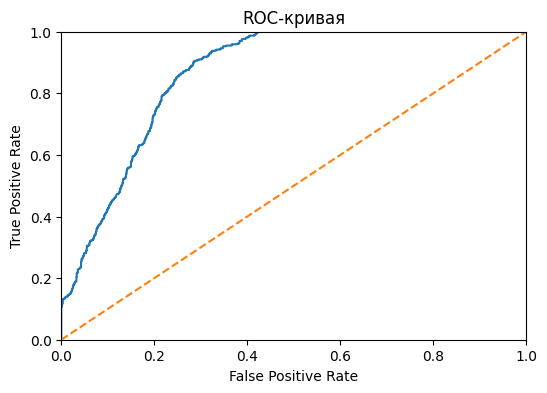

In [89]:
predicted_probalities = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()



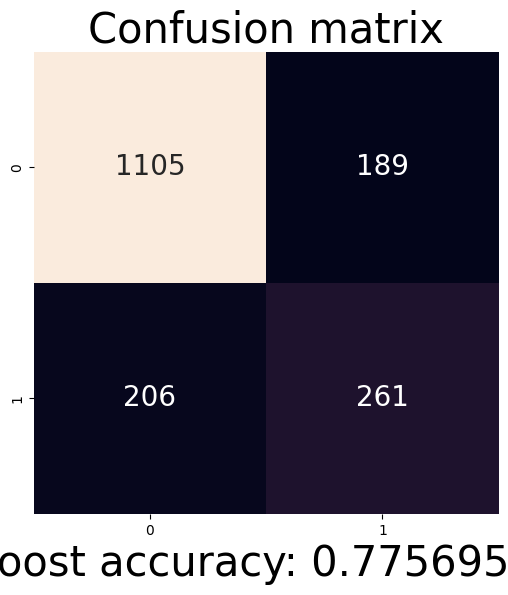

In [90]:
predictions = model.predict(features_test)

labels = [0, 1]
plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(target_test, predictions),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.xlabel(
    f"model Catboost аccuracy: {accuracy_score(target_test, predictions)}",
    fontsize=30)
plt.show()

Learning rate set to 0.020969
0:	learn: 0.6771158	total: 7.77ms	remaining: 7.76s
1:	learn: 0.6542432	total: 14.3ms	remaining: 7.12s
2:	learn: 0.6301939	total: 18.6ms	remaining: 6.17s
3:	learn: 0.6101889	total: 24.6ms	remaining: 6.12s
4:	learn: 0.5860862	total: 27.5ms	remaining: 5.48s
5:	learn: 0.5728100	total: 34.1ms	remaining: 5.65s
6:	learn: 0.5619922	total: 38.7ms	remaining: 5.49s
7:	learn: 0.5467613	total: 44.9ms	remaining: 5.57s
8:	learn: 0.5382643	total: 51.2ms	remaining: 5.63s
9:	learn: 0.5307459	total: 55.8ms	remaining: 5.52s
10:	learn: 0.5231455	total: 60.5ms	remaining: 5.43s
11:	learn: 0.5124705	total: 65.1ms	remaining: 5.36s
12:	learn: 0.5029647	total: 70.8ms	remaining: 5.37s
13:	learn: 0.4961583	total: 75.8ms	remaining: 5.34s
14:	learn: 0.4853315	total: 81ms	remaining: 5.32s
15:	learn: 0.4780777	total: 86.3ms	remaining: 5.31s
16:	learn: 0.4724565	total: 89.2ms	remaining: 5.16s
17:	learn: 0.4683285	total: 94.5ms	remaining: 5.16s
18:	learn: 0.4643563	total: 101ms	remaining: 5

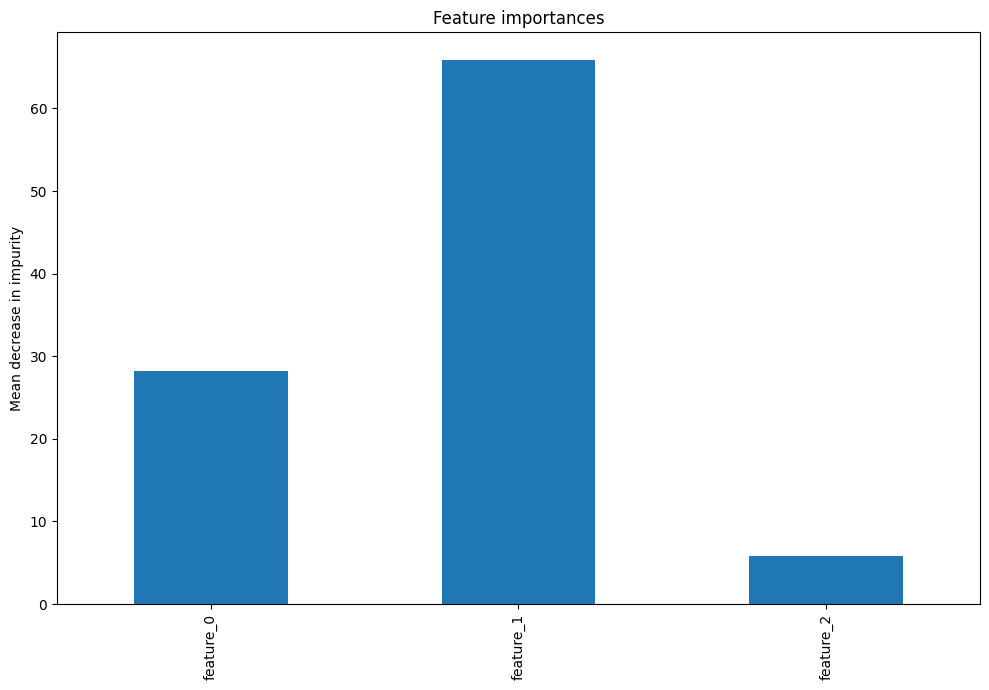

In [91]:
feature_names = [f'feature_{i}' for i in range(features_train.shape[1])]

model = CatBoostClassifier(random_state=RANDOM_STATE)
model.fit(features_train, target_train)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Шаг 5. Общий вывод по работе

1. На начальном этапе исследования были загружены необходимые библиотеки для исследования, а также выведены файлы, содержащиеся в базе данных.

2. В ходе предоработки данных проверены датасеты на пропуски, дубликаты и пустые значения. Дубликатов обнаружено не было, однако были пропуски в `EndDate` и `TotalCharges`. Пропуски в `EndDate` а пропуски в `TotalCharges` мы решили заполнить нулями, поскольку был небольшой процент от выборки в 11 строк. При рассмотрении столбца `EndDate` мы заметили 2 ошибки, а именно, что были данные, где клиент ушёл и у нас не отмечена дата окончания срока действия договора `EndDate`. Другая - Клиент пользуется услугой, но не имеются его общие расходы `TotalCharges`. В итоге было решено исправить итоговую сумму и дату конца договора. Далее мы заметили пропуски из-за несоответствия размерности строк. В итоге мы решили заполнить имеющиеся пропуски наиболее часто повторяющимся значением. Затем мы объединили таблицы в единый датасет и опредилили портреттипичного клиента, который готов расторгнуть договор с компанией по оказываемым услугами рассмотрели взаимозависимости меду признаками на матрице корреляций признаков.

3. Была разделена выбока на обучающую и тестовую в соотношении 1 к 4. Было рассмотрено 5 моделей и были выявлены лучшие показатели метрик с помощью кросс-валидации. Также была создана константная модель для сравнения с другими моделями. Лучше всего себя показала модель логистической регрессии и Catboost со средним значением качества модели на кросс-валидации 0.59 и ROC AUC: 0.824. Поскольку мы можем протестировать только одну модель, выберем Catboost поскольку он способен обрабатывать сложные нелинейные зависимости и автоматически управлять категориальными признаками.

Были получены следующие результаты по наилучшим параметрам метрики cross_val, не считая константной модели и модели нейронной сети:

* Константная модель: 0.5
* Логистическая регрессия: 0.8447910385752312
* Решающее дерево: 0.8557099026427637
* Случайный лес: 0.8820026067326501
* Catboost: 0.8913367501507419
* Модель нейронной сети: Accuracy: 0.7791027825099376

4. Во время тестирования модели Catboost получено значение метрики ROC AUC 0.92, что больше заявленного по условию задачи (0.85) Благодаря применению метода балансировки класса Upsampling нам удалось повысить метрику качества модели. Также мы проверили модель на дамми-ловушку.

5. В качестве улучшения работы модели можно предложить проводить более регулярные исследования (панель), а также собирать больший массив опросного исследования и чётко фиксировать дату окончания срока действия договора и общие расходы клиента, чтобы более качественно проводить исследование в новой итерации. Модель также может быть использована для улучшения потока клиентов при учёте слабых сторон компании.